# Importing Dependencies

In [1]:
import pandas as pd,numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [3]:
df = pd.read_csv('laptop_data.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


# Feature Engineering

In [5]:
df['Ram'] = df['Ram'].str[:-2].astype('int8')
df['Weight'] = df['Weight'].str[:-2].astype('float32')

In [6]:
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
df['ips'] = df['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)

In [7]:
res_ = df['ScreenResolution'].str.split(' ').str[-1].str.split('x')
df['xres'] = res_.str[0].astype('int')
df['yres'] = res_.str[1].astype('int')

### PPI


$$
TPI = \sqrt{PPI^2} = \sqrt{\left(\frac{width_{pixels}}{width_{inches}}\right)^2 + \left(\frac{height_{pixels}}{height_{inches}}\right)^2}
$$


In [8]:
df['ppi'] = ((df['xres']**2) + (df['yres']**2))**0.5 / df['Inches']

### Cpu Name

In [9]:
df['Cpu_name'] = df['Cpu'].str.split(' ').str[0:3].str.join(' ')

In [10]:
def fetch_processor(text: str) -> str:
    if text == 'Intel Core i5' or text == 'Intel Core i7' or text == 'Intel Core i3':
        return text
    else:
        if text.split()[0] == 'Intel':
            return 'Other Intel Processor'
        elif text.split()[0] == 'AMD':
            return 'AMD Processor'
        else:
            return text.split()[0]

In [11]:
df['Cpu_brand']= df['Cpu_name'].apply(fetch_processor)

### CPU Category

In [12]:
df['cpu_cat'] = df['Cpu'].str.split(' ').str[3].str.split('').str[-2]

In [13]:
def cpu_cat(row):
    company = row['Company']
    cpu = row['Cpu']
    if company == 'Apple':
        return 'High Performance'
    else:
        if cpu =='H':
            return 'High Performance'
        elif cpu=='P':
            return 'Balance of Performance'
        else:
            return 'Ultra low power'

In [14]:
df['CPU_Category'] = df.apply(cpu_cat, axis=1)

### Memory

In [15]:
memory_ = df['Memory'].str.replace('GB','').str.replace('TB','000')
memory_ = memory_.str.split('+', n=1, expand = True)

first = memory_[0].str.strip()
second = memory_[1].str.strip().fillna('0')

df['Layer1HDD'] = first.apply(lambda x: 1 if 'HDD' in x else 0)
df['Layer1SSD'] = first.apply(lambda x: 1 if 'SSD' in x else 0)
df['Layer1Hybrid'] = first.apply(lambda x: 1 if 'Hybrid' in x else 0)
df['Layer1Flash_storage'] = first.apply(lambda x: 1 if 'Flash Storage' in x else 0)

df['first']=first.astype('str').str.replace(r'\D', '', regex = True).astype('int')

In [16]:
df['Layer2HDD'] = second.apply(lambda x: 1 if 'HDD' in x else 0)
df['Layer2SSD'] = second.apply(lambda x: 1 if 'SSD' in x else 0)
df['Layer2Hybrid'] = second.apply(lambda x: 1 if 'Hybrid' in x else 0)
df['Layer2Flash_storage'] = second.apply(lambda x: 1 if 'Flash Storage' in x else 0)

df['second'] = second.str.replace(r'\D','', regex = True).astype('int')

In [17]:
df['HDD'] = (df['first'] * df['Layer1HDD'] + df['second'] * df['Layer2HDD'])
df['SSD'] = (df['first'] * df['Layer1SSD'] + df['second'] * df['Layer2SSD'])
df['Hybrid'] = (df['first'] * df['Layer1Hybrid'] + df['second'] * df['Layer2Hybrid'])
df['Flash_storage'] = (df['first']*df['Layer1Flash_storage'] + df['second'] * df['Layer2Flash_storage'])

### GPU

In [18]:
df['Gpu_brand'] = df['Gpu'].str.split(' ').str[0]
df = df[df['Gpu_brand'] != 'ARM']

In [19]:
df['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux', 'Android',
       'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

In [20]:
def cat_os(os: str) -> str:
    if os == 'Windows 10' or os == 'Windows 7' or os == 'Windows 10 S':
        return 'Windows'
    elif os == 'macOS' or os == 'Mac OS X':
        return 'Mac'
    else:
        return 'other/ linux/ No os'

In [21]:
df['os'] = df['OpSys'].apply(cat_os)

### Dropping columns

In [22]:
df = df.drop(['ScreenResolution', 'Inches','yres','xres','cpu_cat','Cpu_name','Cpu','Layer1HDD', 'Layer1SSD', 'Layer1Hybrid', 'Layer1Flash_storage',
       'first', 'Layer2HDD', 'Layer2SSD', 'Layer2Hybrid',
       'Layer2Flash_storage', 'second', 'Memory','Hybrid','Flash_storage','OpSys', 'Gpu'], axis =1)

### FInal Data

In [23]:
df.head()

,Company,TypeName,Ram,Weight,Price,Touchscreen,ips,ppi,Cpu_brand,CPU_Category,HDD,SSD,Gpu_brand,os
0,Apple,Ultrabook,8,1.37,71378.6832,0,1,226.983005,Intel Core i5,High Performance,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,47895.5232,0,0,127.677940,Intel Core i5,High Performance,0,0,Intel,Mac
2,HP,Notebook,8,1.86,30636.0000,0,0,141.211998,Intel Core i5,Ultra low power,0,256,Intel,other/ linux/ No os
3,Apple,Ultrabook,16,1.83,135195.3360,0,1,220.534624,Intel Core i7,High Performance,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,96095.8080,0,1,226.983005,Intel Core i5,High Performance,0,256,Intel,Mac


# EDA

### Statistics

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1302 entries, 0 to 1302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1302 non-null   object 
 1   TypeName      1302 non-null   object 
 2   Ram           1302 non-null   int8   
 3   Weight        1302 non-null   float32
 4   Price         1302 non-null   float64
 5   Touchscreen   1302 non-null   int64  
 6   ips           1302 non-null   int64  
 7   ppi           1302 non-null   float64
 8   Cpu_brand     1302 non-null   object 
 9   CPU_Category  1302 non-null   object 
 10  HDD           1302 non-null   int64  
 11  SSD           1302 non-null   int64  
 12  Gpu_brand     1302 non-null   object 
 13  os            1302 non-null   object 
dtypes: float32(1), float64(2), int64(4), int8(1), object(6)
memory usage: 138.6+ KB


In [25]:
df.describe()

,Ram,Weight,Price,Touchscreen,ips,ppi,HDD,SSD
count,1302.000000,1302.000000,1302.000000,1302.000000,1302.00000,1302.000000,1302.000000,1302.000000
mean,8.385561,2.039416,59889.058673,0.146697,0.27957,146.568497,421.013825,183.874040
std,5.085166,0.665274,37251.183866,0.353940,0.44896,43.069016,580.051728,186.969314
min,2.000000,0.690000,9270.720000,0.000000,0.00000,90.583402,0.000000,0.000000
25%,4.000000,1.500000,31914.720000,0.000000,0.00000,127.335675,0.000000,0.000000
50%,8.000000,2.040000,52107.840000,0.000000,0.00000,141.211998,0.000000,256.000000
75%,8.000000,2.300000,79303.816800,0.000000,1.00000,157.350512,1000.000000,256.000000
max,64.000000,4.700000,324954.720000,1.000000,1.00000,352.465147,10000.000000,1024.000000


### Correlation with Price

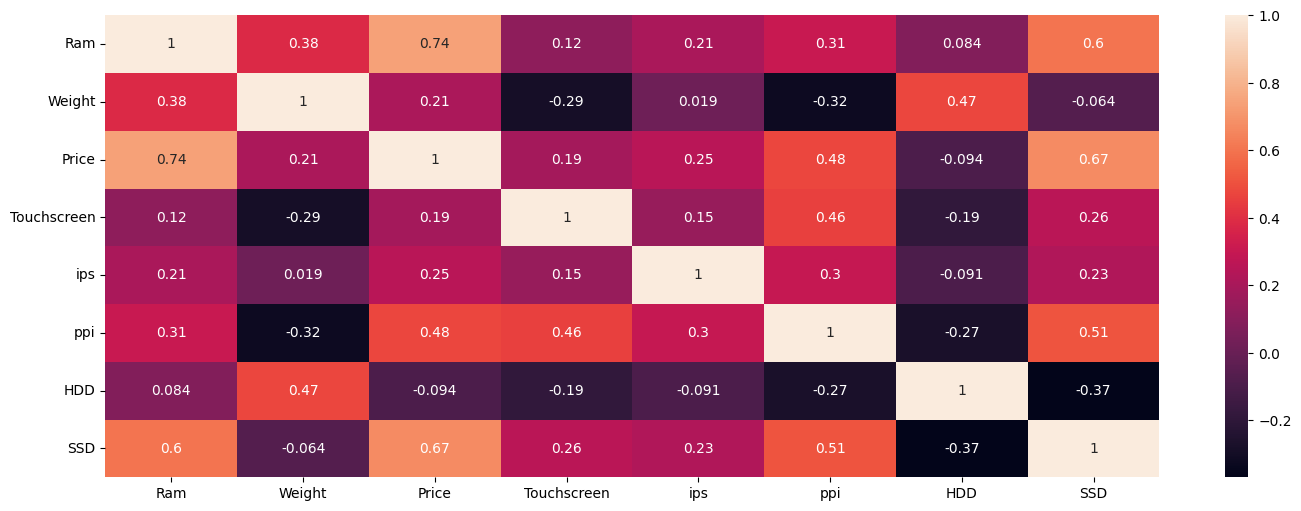

In [26]:
fig, ax = plt.subplots(figsize = (17,6))
sns.heatmap(df.select_dtypes(exclude = 
                 ['object']).corr(), annot=True, ax = ax)
plt.show()

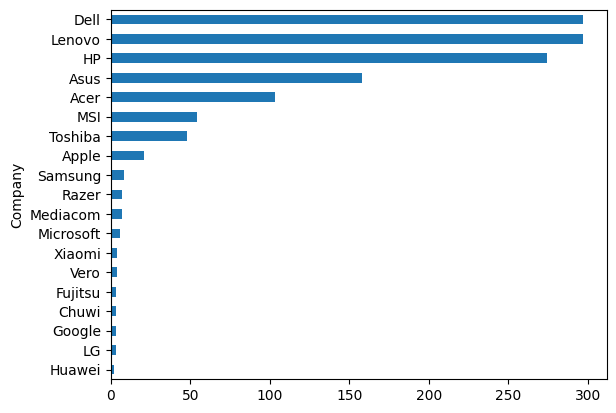

In [27]:
df['Company'].value_counts(ascending = True).plot(kind = 'barh')
plt.show()

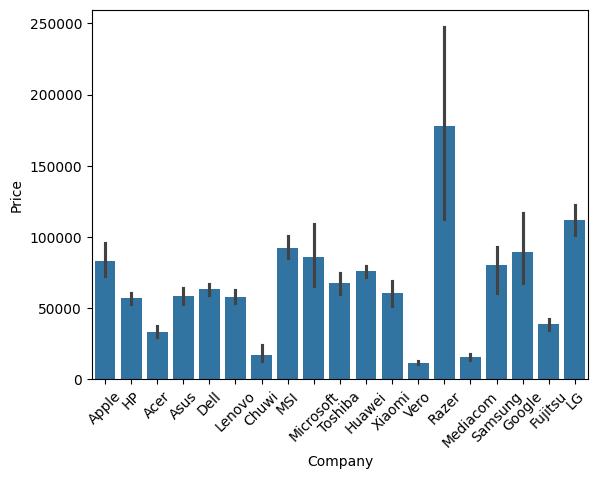

In [28]:
sns.barplot(x = df['Company'], y = df['Price'])
plt.xticks(rotation = 45)
plt.show()

laptop prices vary by the company.

<Axes: ylabel='TypeName'>

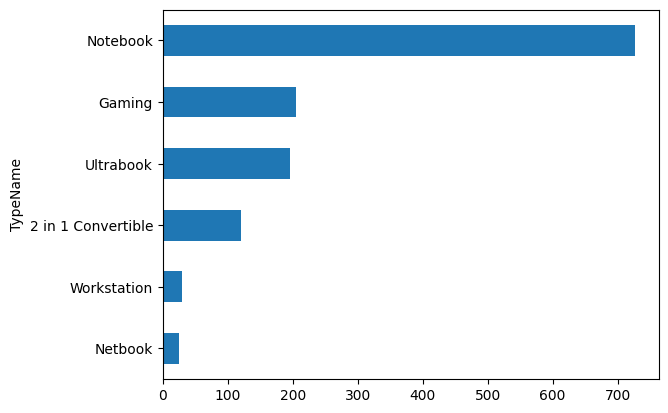

In [29]:
df['TypeName'].value_counts(ascending = True).plot(kind = 'barh')

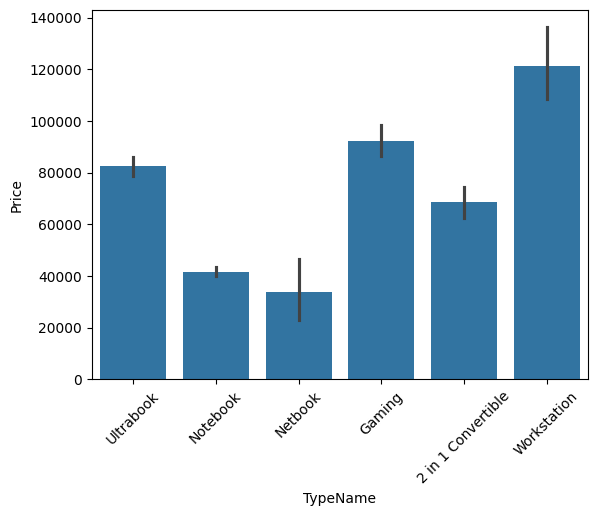

In [30]:
sns.barplot(x = df['TypeName'], y = df['Price'])
plt.xticks(rotation = 45)
plt.show()

# Model Creation

### Train Test Split

In [31]:
x = df.drop('Price', axis = 1)
y = np.log(df['Price'])

In [32]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1302 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1302 non-null   object 
 1   TypeName      1302 non-null   object 
 2   Ram           1302 non-null   int8   
 3   Weight        1302 non-null   float32
 4   Touchscreen   1302 non-null   int64  
 5   ips           1302 non-null   int64  
 6   ppi           1302 non-null   float64
 7   Cpu_brand     1302 non-null   object 
 8   CPU_Category  1302 non-null   object 
 9   HDD           1302 non-null   int64  
 10  SSD           1302 non-null   int64  
 11  Gpu_brand     1302 non-null   object 
 12  os            1302 non-null   object 
dtypes: float32(1), float64(1), int64(4), int8(1), object(6)
memory usage: 128.4+ KB


In [33]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 42, test_size=0.15)

Splitting Independent variable *X* and dependent variable *y* with random state of 2 and test size of 0.15.

In [34]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = LinearRegression()

pipe = Pipeline([
    ('step1',step1),
    ('step2', step2)
])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)

print(f"R2 score = {r2_score(y_test,y_pred)} \n the MAE is {mean_absolute_error(y_test,y_pred)}")

R2 score = 0.7925376029049772 
 the MAE is 0.21373185083694718


### Ridge

In [35]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = Ridge(alpha = 10)

pipe1 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe1.fit(x_train,y_train)
y_pred1 = pipe.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.7925376029049772 
 the MAE is 0.21373185083694718


In [36]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = Lasso(alpha = 0.001)

pipe2 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe2.fit(x_train,y_train)
y_pred1 = pipe2.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.7868944979013376 
 the MAE is 0.21865281716251295


In [37]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = KNeighborsRegressor(n_neighbors=7)

pipe3 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe3.fit(x_train,y_train)
y_pred1 = pipe3.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.7569502689812004 
 the MAE is 0.22737485746404565


In [38]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = DecisionTreeRegressor(max_depth = 9)

pipe3 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe3.fit(x_train,y_train)
y_pred1 = pipe3.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.82523957229396 
 the MAE is 0.19195608383626267


In [39]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = SVR(kernel='rbf', C = 10000, epsilon=0.1)

pipe3 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe3.fit(x_train,y_train)
y_pred1 = pipe3.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.8090259763602194 
 the MAE is 0.19382585922299198


In [40]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = RandomForestRegressor(n_estimators=150, random_state=12, max_samples=0.7, max_features=0.79, max_depth=15)

pipe3 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe3.fit(x_train,y_train)
y_pred1 = pipe3.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.8623269384747831 
 the MAE is 0.16578806169790516


In [41]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = AdaBoostRegressor(n_estimators=20, learning_rate=1.0)

pipe3 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe3.fit(x_train,y_train)
y_pred1 = pipe3.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.7371423458075324 
 the MAE is 0.25245009134343255


In [42]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = GradientBoostingRegressor(n_estimators=450, learning_rate=1.0, max_depth=9)

pipe3 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe3.fit(x_train,y_train)
y_pred1 = pipe3.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.8284983154762758 
 the MAE is 0.18556318050644463


In [43]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0,1,7,8,11,12])
], remainder = 'passthrough')

step2 = XGBRegressor(n_estimators = 45, max_depth = 5, learning_rate = 0.5)

pipe3 = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe3.fit(x_train,y_train)
y_pred1 = pipe3.predict(x_test)
print(f"R2 score = {r2_score(y_test,y_pred1)} \n the MAE is {mean_absolute_error(y_test,y_pred1)}")

R2 score = 0.8753582420587099 
 the MAE is 0.15968478643201917


In [55]:
from sklearn.ensemble import VotingRegressor,StackingRegressor

step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse_output=False,drop='first', handle_unknown='ignore'),[0,1,7,8,11,12])
],remainder='passthrough')


estimators = [
    ('rf', RandomForestRegressor(n_estimators=350,random_state=3,max_samples=0.5,max_features=0.75,max_depth=15)),
    ('gbdt',GradientBoostingRegressor(n_estimators=100,max_features=0.5)),
    ('xgb', XGBRegressor(n_estimators=25,learning_rate=0.3,max_depth=5))
]

step2 = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=100))

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8478520898058277
MAE 0.18161102353901037


In [50]:
import pickle

In [56]:
pickle.dump(df,open('df.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))

In [60]:
x.iloc[3].values

array(['Apple', 'Ultrabook', 16, 1.83, 0, 1, 220.53462386625827,
       'Intel Core i7', 'High Performance', 0, 512, 'AMD', 'Mac'],
      dtype=object)

In [53]:
x.iloc[].columns

Index(['Company', 'TypeName', 'Ram', 'Weight', 'Price', 'Touchscreen', 'ips',
       'ppi', 'Cpu_brand', 'CPU_Category', 'HDD', 'SSD', 'Gpu_brand', 'os'],
      dtype='object')

In [62]:
query = np.array([['Apple', 'Ultrabook', 16, 1.83, 0, 1, 220.53462386625827,
       'Intel Core i7', 'High Performance', 0, 512, 'AMD', 'Mac']])

In [65]:
# Ensure the query is a DataFrame with the correct column names
query_df = pd.DataFrame(query, columns=x_train.columns)

# Use the pipeline to preprocess the query
pipe.predict(query_df)


array([11.72654231])

In [66]:
df.columns

Index(['Company', 'TypeName', 'Ram', 'Weight', 'Price', 'Touchscreen', 'ips',
       'ppi', 'Cpu_brand', 'CPU_Category', 'HDD', 'SSD', 'Gpu_brand', 'os'],
      dtype='object')